# Arm Angles

This notebook serves as a way to estimate the arm angle of a pitcher using Baseball Savant pitch-by-pitch data. The methodology used comes from this article from Logan Mottely posted on [RundownBaseball.com](https://web.archive.org/web/20230123183755/https://www.rundownbaseball.com/project/calculating-arm-angles-using-statcast-data/). 

It uses the player height, release_pos_x, release_pos_y, and release_pos_z to form a triangle and calculate the angle of the hypotenuse (which is the arm angle).

## Import Packages

In [2]:
from highlight_text import fig_text, ax_text
import pandas as pd
import numpy as np
import pybaseball as pyb
import datetime as dt
import requests
import statsapi


## Retrieve Player Info from MLBStatsAPI

In [3]:
def fetch_team_data():
    """Fetches MLB team data from the API."""
    url = 'https://statsapi.mlb.com/api/v1/teams?sportId=1'
    try:
        response = requests.get(url)
        teams = response.json()
        team_df = pd.DataFrame(teams['teams'])
        team_df = team_df[['id', 'name', 'teamCode', 'fileCode', 'abbreviation', 'locationName', 'shortName']]
        return team_df
    except Exception as e:
        print(f"Failed to fetch team data: {e}")
        return pd.DataFrame()

def fetch_roster(team_id, season):
    """Fetches the roster for a team for a given season."""
    try:
        response = statsapi.get("team_roster", {
            "teamId": team_id,
            "rosterType": "fullRoster",
            "season": season,
            "hydrate": "person"
        })
        return response['roster']
    except KeyError:
        return []
    
def convert_height_to_inches(height_str):
    """Converts height from feet and inches to inches."""
    try:
        feet, inches = height_str.split("'")
        return int(feet.strip()) * 12 + int(inches.replace('"', '').strip())
    except (ValueError, AttributeError):
        return None

def process_player_info(roster, season, team_id):
    """Processes player data from roster."""
    player_data = []
    for player in roster:
        person = player['person']
        person['primaryPosition'] = person['primaryPosition']['abbreviation']
        person['batSide'] = person['batSide']['code']
        person['pitchHand'] = person['pitchHand']['code']
        person['season'] = season
        person['teamId'] = team_id
        player_data.append(person)
    return player_data

def build_player_info_df():
    teams = fetch_team_data()
    if teams.empty:
        print("No team data available.")
        return
    player_info = pd.DataFrame()
    
    for season in ['2024']:
        for team_id in teams['id']:
            roster = fetch_roster(team_id, season)
            player_data = process_player_info(roster, season, team_id)
            player_info = pd.concat([player_info, pd.DataFrame(player_data)], ignore_index=True)

    player_info['height'] = player_info['height'].apply(convert_height_to_inches)
    player_info = player_info[['id', 'fullName', 'height', 'weight', 'teamId']].drop_duplicates()
    player_info.to_csv('data/playerInfo.csv', index=False)
    print('Data collection complete. Results saved to file.')
    return player_info

In [4]:
player_info = build_player_info_df()
player_info.head()

Data collection complete. Results saved to file.


,id,fullName,height,weight,teamId
0,605156,Aaron Brooks,76.0,230.0,133
1,647351,Abraham Toro,72.0,223.0,133
2,661309,Adrián Martínez,74.0,215.0,133
3,683548,Adriel Gonzalez,74.0,145.0,133
4,649557,Aledmys Díaz,73.0,195.0,133


## Calculate Arm Angles

In [5]:
# Merge the Pitcher Info w/ Height from MLBStatsAPI
def merge_pitcher_info(df):
    pitcher_info = pd.read_csv('data/playerInfo.csv', usecols=['id', 'fullName', 'height'])
    pitcher_info.rename(columns={'fullName': 'pitcher_name',
                                'id': 'pitcher'}, inplace=True)
    
    pitcher_info = pitcher_info.drop_duplicates(subset='pitcher')
    return df.merge(pitcher_info, left_on='pitcher', right_on='pitcher', how='left')

# Calculate the Arm Angle from Baseball Savant data
def calculate_arm_angles(df):
    df['release_pos_x'] = df['release_pos_x'] * 12
    df['release_pos_z'] = df['release_pos_z'] * 12
    df['shoulder_pos'] = df['height'] * 0.70 # Calculate the shoulder position based on height
    df['Adj'] = df['release_pos_z'] - df['shoulder_pos'] # Adjacent side length
    df['Opp'] = abs(df['release_pos_x']) # Calculate the opposite side length
    df['arm_angle_rad'] = np.arctan2(df['Opp'], df['Adj']) # Calculate the arm angle in radians
    df['arm_angle'] = np.degrees(df['arm_angle_rad']) # Convert the arm angle to degrees
    df.drop(['Opp', 'arm_angle_rad'], axis=1, inplace=True)

    return df

def arm_angle_categories(df):
    bins = [0, 30, 60, 90, 120, 180]
    labels = ['Overhand', 'High Three-Quarters', 'Low Three-Quarters', 'Sidearm', 'Submarine']
    df['arm_angle_type'] = pd.cut(df['arm_angle'], bins=bins, labels=labels, right=False)

    return df

### Calculate Pitch Level Arm Angles

In [6]:
# Enable pybaseball cache
pyb.cache.enable()
data = pyb.statcast(start_dt='2024-01-01', end_dt='2024-12-31')

data = data[data['game_type'] == 'R']
data = merge_pitcher_info(data)
data = calculate_arm_angles(data)
data = arm_angle_categories(data)
data[['pitcher', 'pitcher_name', 'arm_angle', 'arm_angle_type']].head()

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [01:31<00:00,  2.70it/s]
/opt/homebrew/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


,pitcher,pitcher_name,arm_angle,arm_angle_type
0,592155,Cam Booser,61.285686,Low Three-Quarters
1,592155,Cam Booser,65.933543,Low Three-Quarters
2,592155,Cam Booser,58.036507,High Three-Quarters
3,592155,Cam Booser,60.194424,Low Three-Quarters
4,592155,Cam Booser,59.617991,High Three-Quarters


### Group by Pitcher

In [7]:
# Group By Pitcher
pitcher_data = data.groupby(['pitcher', 'pitcher_name', 'p_throws']).agg({'height': 'mean',
                                                                          'shoulder_pos': 'mean',
                                                                          'release_pos_x': 'mean',
                                                                          'release_pos_z': 'mean',
                                                                          'arm_angle': 'mean',
                                                                          }).reset_index()
pitcher_data = arm_angle_categories(pitcher_data)
pitcher_data.to_csv('data/overallArmAngles.csv', index=False)
pitcher_data.head(10)

,pitcher,pitcher_name,p_throws,height,shoulder_pos,release_pos_x,release_pos_z,arm_angle,arm_angle_type
0,434378,Justin Verlander,R,77.0,53.9,-18.605239,85.151726,30.683334,High Three-Quarters
1,445276,Kenley Jansen,R,77.0,53.9,-25.255575,77.033982,47.398249,High Three-Quarters
2,445926,Jesse Chavez,R,73.0,51.1,-19.203907,61.68586,61.068203,Low Three-Quarters
3,450203,Charlie Morton,R,77.0,53.9,-28.209073,66.229091,66.390007,Low Three-Quarters
4,455119,Chris Martin,R,80.0,56.0,-35.591299,72.784675,64.684428,Low Three-Quarters
5,458677,Justin Wilson,L,74.0,51.8,17.321558,76.246234,34.981121,High Three-Quarters
6,458681,Lance Lynn,R,77.0,53.9,-39.129749,67.222195,71.081061,Low Three-Quarters
7,471911,Carlos Carrasco,R,76.0,53.2,-16.604861,70.837917,43.186336,High Three-Quarters
8,472610,Luis García,R,74.0,51.8,-27.285676,75.287838,49.22294,High Three-Quarters
9,489119,Wade Miley,L,73.0,51.1,22.749153,74.842373,43.744578,High Three-Quarters


### Group by Pitcher and Pitch Type

In [8]:
# Group the data by pitcher & pitch type 
arsenal_arm_angles = data.groupby(['pitcher', 'pitcher_name', 'p_throws', 'pitch_type']).agg({'height': 'mean',
                                                                                              'shoulder_pos': 'mean',
                                                                                              'release_pos_x': 'mean',
                                                                                              'release_pos_z': 'mean',
                                                                                              'arm_angle': 'mean',
                                                                                              }).reset_index()

arsenal_arm_angles = arm_angle_categories(arsenal_arm_angles)
arsenal_arm_angles.head(10)


,pitcher,pitcher_name,p_throws,pitch_type,height,shoulder_pos,release_pos_x,release_pos_z,arm_angle,arm_angle_type
0,434378,Justin Verlander,R,CH,77.0,53.9,-19.634483,85.33931,31.918061,High Three-Quarters
1,434378,Justin Verlander,R,CU,77.0,53.9,-20.022778,84.748333,32.912248,High Three-Quarters
2,434378,Justin Verlander,R,FF,77.0,53.9,-17.282773,85.472773,28.644333,Overhand
3,434378,Justin Verlander,R,SL,77.0,53.9,-19.882623,84.703607,32.769111,High Three-Quarters
4,445276,Kenley Jansen,R,FC,77.0,53.9,-25.436066,77.008525,47.651066,High Three-Quarters
5,445276,Kenley Jansen,R,SI,77.0,53.9,-21.465882,77.491765,42.251251,High Three-Quarters
6,445276,Kenley Jansen,R,SL,77.0,53.9,-25.807059,77.032941,48.009416,High Three-Quarters
7,445926,Jesse Chavez,R,CH,73.0,51.1,-19.369091,62.078182,60.436862,Low Three-Quarters
8,445926,Jesse Chavez,R,CU,73.0,51.1,-17.737143,64.2,53.513835,High Three-Quarters
9,445926,Jesse Chavez,R,FC,73.0,51.1,-20.009114,60.964557,63.739864,Low Three-Quarters


## Plot Arm Angles

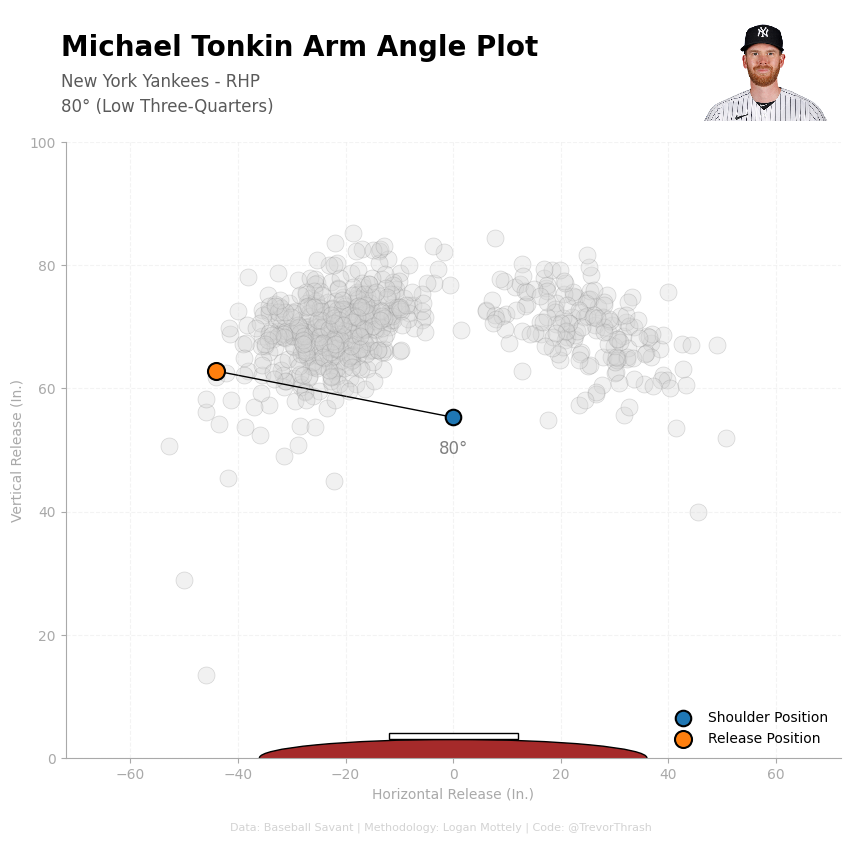

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Plot the arm angle for a pitcher
def plot_pitcher_arm_angle(pitcher_name, pitcher_data):
    pitcher = pitcher_data[pitcher_data['pitcher_name'] == pitcher_name]

    fig, ax = plt.subplots(figsize=(10, 8))
    x_values = np.zeros(len(pitcher['release_pos_x']))
    plt.scatter(x_values, pitcher['shoulder_pos'], s=125, lw=1.5, edgecolors='k', zorder=3, label='Shoulder Position')
    plt.scatter(pitcher['release_pos_x'], pitcher['release_pos_z'], s=150, lw=1.5, edgecolors='k', zorder=3, label='Release Position')

    # Draw a line between the shoulder and release point
    for i in range(len(pitcher)):
        plt.plot([0, pitcher['release_pos_x'].iloc[i]], [pitcher['shoulder_pos'].iloc[i], pitcher['release_pos_z'].iloc[i]], 'k-', lw=1, zorder=1)

    # Draw the mound as an ellipse
    mound = patches.Ellipse((0, 0), width=72, height=6, angle=0, facecolor='brown', edgecolor='black', linewidth=1, zorder=2)
    plt.gca().add_patch(mound)

    # Draw the rubber as a white rectangle with a black border
    rubber = patches.Rectangle((-12, 3), width=24, height=1, angle=0, edgecolor='black', facecolor='white', zorder=3)
    plt.gca().add_patch(rubber)
    
    # Plot the distribution of league release points
    plt.scatter(pitcher_data['release_pos_x'], pitcher_data['release_pos_z'], s=150, lw=0.5, edgecolors='gray', c='lightgray', alpha=0.3, zorder=0)

    # Format the arm angle as an integer
    arm_angle = int(pitcher['arm_angle'].iloc[0])
    arm_angle_type = pitcher['arm_angle_type'].iloc[0]
    p_throws = pitcher['p_throws'].iloc[0]

    # Get the current team name from MLBStatsAPI
    player_data = statsapi.lookup_player(f'{pitcher_name}')
    team_id = player_data[0]['currentTeam']['id']
    team_inf = statsapi.get('team', {'teamId': team_id})
    team_name = team_inf['teams'][0]['name']

    fig_text(
        x = 0.12, y = .98, 
        s = f"{pitcher_name} Arm Angle Plot",
        va = "bottom", ha = "left",
        fontsize = 20, color = "black", weight = "bold"
        )

    fig_text(
        x = 0.12, y = 0.9555, 
        s = f"{team_name} - {p_throws}HP",
        va = "center", ha = "left",
        fontsize = 12, color = "#5A5A5A",
        )
    
    fig_text(
        x = 0.12, y = 0.9125, 
        s = f"{arm_angle}° ({arm_angle_type})",
        va = "bottom", ha = "left",
        fontsize = 12, color = "#5A5A5A",
        )

    # Annotate the shoulder_pos with the words 'Shoulder Position'
    if pitcher['arm_angle'].iloc[0] > 90:
        ax_text(
        x = 0, y = pitcher['shoulder_pos'].mean() + 5, 
        s = f"{arm_angle}°",
        va = "center", ha = "center",
        fontsize = 12, color = "gray",
        )
    else:
        ax_text(
        x = 0, y = pitcher['shoulder_pos'].mean() - 5, 
        s = f"{arm_angle}°",
        va = "center", ha = "center",
        fontsize = 12, color = "gray",
        )
        

    fig_text(
        x = 0.5, y = 0.03, 
        s = f"Data: Baseball Savant | Methodology: Logan Mottely | Code: @TrevorThrash",
        va = "top", ha = "center",
        fontsize = 8, color = "lightgray",
    )

    try:
        img_path = f'player_img/{pitcher_name}.png'
        image = plt.imread(img_path)
        imagebox = OffsetImage(image, zoom=0.3)
        ab = AnnotationBbox(imagebox, (0.9, 1.12), frameon=False, xycoords='axes fraction', boxcoords="axes fraction")
        ax.add_artist(ab)
    except FileNotFoundError:
        pass

    ax.set_ylim(0, 100)
    ax.set_xlim(-72, 72)

    # Set tick color
    ax.tick_params(axis='x', colors='darkgray')
    ax.tick_params(axis='y', colors='darkgray')

    # Set axis label color
    ax.yaxis.label.set_color('darkgray')
    ax.xaxis.label.set_color('darkgray')
    
    ax.set_ylabel('Vertical Release (In.)')
    ax.set_xlabel('Horizontal Release (In.)')
    ax.grid(True, linestyle='--', alpha=0.25, color='lightgray')
    ax.legend(loc='lower right', frameon=False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('darkgray')
    plt.show()

plot_pitcher_arm_angle('Michael Tonkin', pitcher_data)

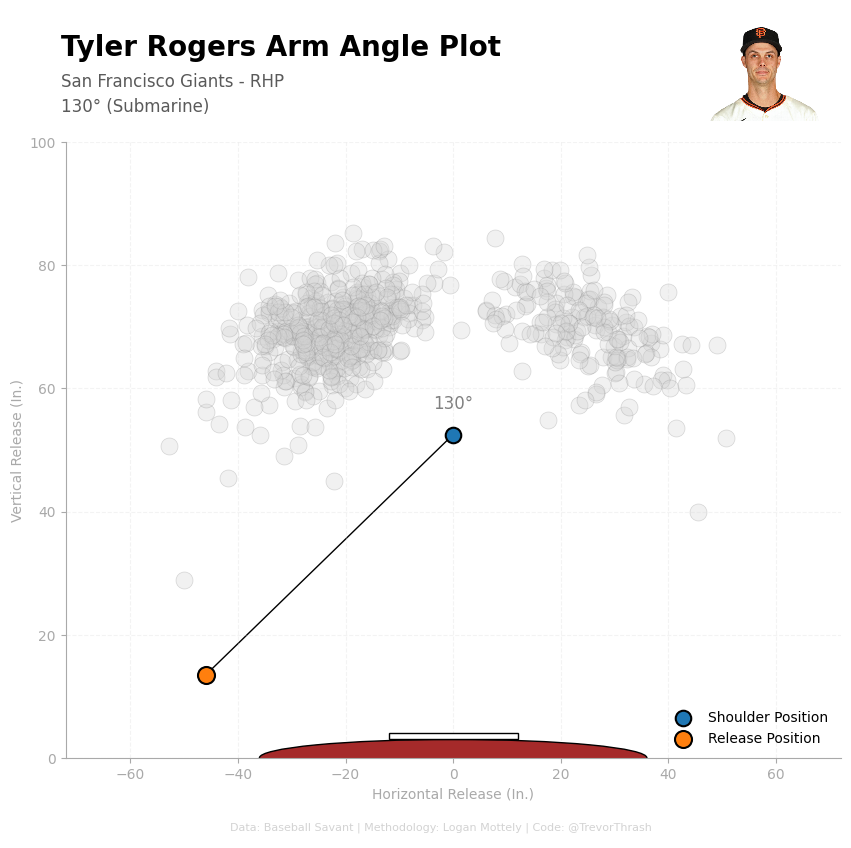

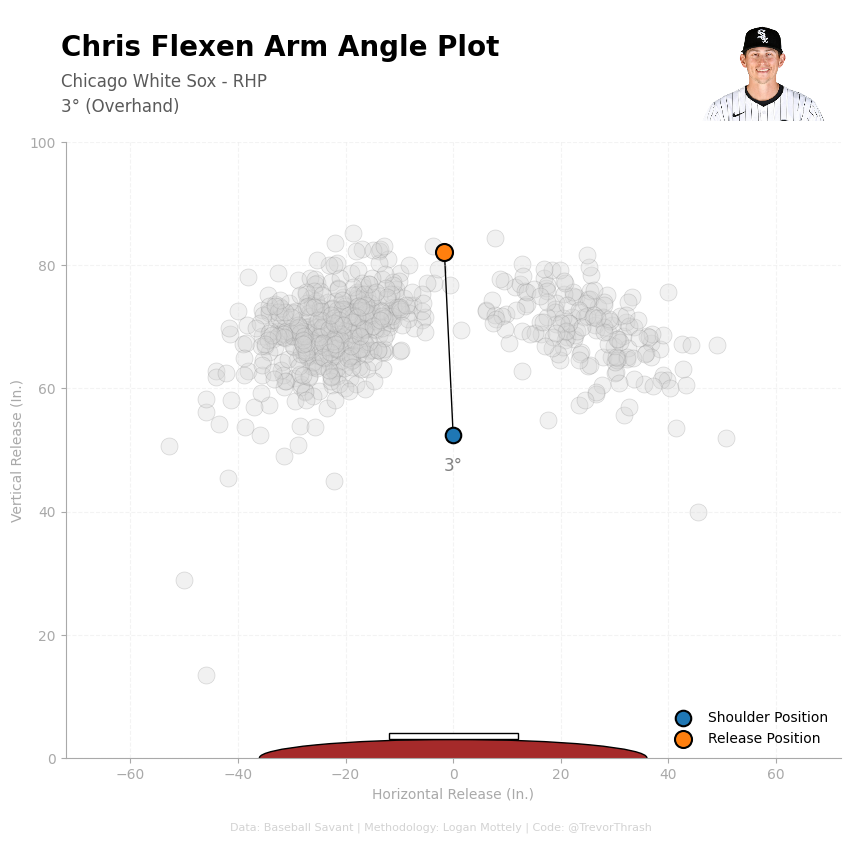

In [62]:
# Highest and lowest arm angle pitchers
highest_arm_angle = pitcher_data[pitcher_data['arm_angle'] == pitcher_data['arm_angle'].max()]
lowest_arm_angle = pitcher_data[pitcher_data['arm_angle'] == pitcher_data['arm_angle'].min()]

plot_pitcher_arm_angle(highest_arm_angle['pitcher_name'].iloc[0], pitcher_data)
plot_pitcher_arm_angle(lowest_arm_angle['pitcher_name'].iloc[0], pitcher_data)

## Espn MLB Player Link

In [11]:
url = 'https://sports.core.api.espn.com/v3/sports/baseball/mlb/athletes?limit=20000'

response = requests.get(url)
data = response.json()
data.keys()

player_data = data['items']
player_data[0]

# Collect the player data from the API
player_info = []
for player in player_data:
    player_info.append({
        'id': player['id'],
        'fullName': player['fullName']
    })

player_info = pd.DataFrame(player_info)
player_info.to_csv('data/espnPlayerInfo.csv', index=False)
player_info.head()

,id,fullName
0,1414,John Franco
1,1759,Jerry Browne
2,1821,Orestes Destrade
3,1986,Mario Diaz
4,2063,Greg Briley


In [12]:
# List of 10 lowest arm angle pitchers
lowest_arm_angle = pitcher_data.sort_values('arm_angle', ascending=False).head(10)
lowest_arm_angle

,pitcher,pitcher_name,p_throws,height,shoulder_pos,release_pos_x,release_pos_z,arm_angle,arm_angle_type
260,643511,Tyler Rogers,R,75.0,52.5,-46.003765,13.451012,130.325098,Submarine
253,643256,Adam Cimber,R,75.0,52.5,-50.101741,28.828496,115.291579,Sidearm
602,687330,Kevin Kelly,R,74.0,51.8,-22.148889,44.908889,107.346106,Sidearm
318,657612,Tim Hill,L,76.0,53.2,45.491759,39.952764,106.201592,Sidearm
307,657044,Ryan Thompson,R,77.0,53.9,-41.902258,45.453548,101.376913,Sidearm
459,670167,John Schreiber,R,74.0,51.8,-31.439178,48.987671,94.977752,Sidearm
164,621016,Jose Cuas,R,75.0,52.5,-52.711751,50.630195,92.020755,Sidearm
72,571948,Hoby Milner,L,75.0,52.5,50.759032,51.870242,90.701888,Sidearm
378,664875,Justin Lawrence,R,75.0,52.5,-35.835806,52.364194,90.189285,Sidearm
573,682175,Joe Jacques,L,76.0,53.2,41.352727,53.603636,89.409074,Low Three-Quarters


In [68]:
def fetch_player_image(player_name):
    player_id = player_info[player_info['fullName'].str.contains(player_name)].iloc[0]['id']
    url = f'https://a.espncdn.com/combiner/i?img=/i/headshots/mlb/players/full/{player_id}.png&w=350&h=254'

    response = requests.get(url)
    with open(f'player_img/{player_name}.png', 'wb') as f:
        f.write(response.content)

# Fetch the player images
fetch_player_image('Michael Tonkin')

In [71]:
# Function to get and process roster
def get_team_roster(team_id):
    roster_data = statsapi.get('team_roster', {
    'teamId': team_id,
    'rosterType': 'depthChart',
    'hydrate': 'status,person(primaryPosition)'
    })

    # Extract relevant fields from the JSON data
    roster_dict = {}
    for player in roster_data['roster']:
        person = player['person']
        player_id = person['id']
        primary_position = person['primaryPosition']['abbreviation']

        # Initialize the player's entry if it does not exist
        if player_id not in roster_dict:
            roster_dict[player_id] = {
                'team_id': team_id,
                'id': player_id,
                'name': person['fullName'],
                'bats': person['batSide']['description'],
                'thdfs': person['pitchHand']['description'],
                'primary_position': primary_position,
                'secondary_positions': set(),
                'status': player['status']['description']
            }

        # Add the secondary position if it is different from the primary position
        if 'position' in player:
            position = player['position']['abbreviation']
            if position != primary_position:
                roster_dict[player_id]['secondary_positions'].add(position)

    # Convert secondary positions sets to sorted lists
    for player_id in roster_dict:
        roster_dict[player_id]['secondary_positions'] = sorted(roster_dict[player_id]['secondary_positions'])

    # Create a DataFrame
    roster_list = list(roster_dict.values())
    roster_df = pd.DataFrame(roster_list)

    # Optionally, if you want to convert the secondary_positions list to a string representation
    roster_df['secondary_positions'] = roster_df['secondary_positions'].apply(lambda x: ', '.join(x))

    # Filter for active players
    roster_df = roster_df[roster_df['status'] == 'Active']

    return roster_df

def update_position(df):
    df['position'] = df['primary_position']
    df.loc[df['primary_position'] == 'P', 'position'] = df['secondary_positions']
    df.loc[df['position'] == '', 'position'] =  df['primary_position']
    df.loc[df['position'] == 'P', 'position'] = 'RP'
    return df

# Get the active roster for the San Francisco Giants
team_id = 147
active_roster = get_team_roster(team_id)
active_roster = update_position(active_roster)
active_roster.head(25)

,team_id,id,name,bats,thdfs,primary_position,secondary_positions,status,position
1,147,592454,Tommy Kahnle,Right,Right,P,,Active,RP
2,147,641656,Ian Hamilton,Right,Right,P,,Active,RP
3,147,624647,Victor González,Left,Left,P,,Active,RP
4,147,657571,Caleb Ferguson,Right,Left,P,,Active,RP
7,147,596133,Luke Weaver,Right,Right,P,,Active,RP
9,147,543859,Michael Tonkin,Right,Right,P,,Active,RP
10,147,676760,Ron Marinaccio,Right,Right,P,,Active,RP
11,147,624431,Jose Trevino,Right,Right,C,,Active,C
12,147,669224,Austin Wells,Left,Right,C,,Active,C
13,147,519203,Anthony Rizzo,Left,Left,1B,,Active,1B


/var/folders/tr/24ngf6ld159361lgswj_6ch00000gn/T/ipykernel_1418/453648012.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(pitcher_names))  # Get a color map with as many colors as pitchers
/var/folders/tr/24ngf6ld159361lgswj_6ch00000gn/T/ipykernel_1418/453648012.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x/12)}' for x in ax.get_xticks()])
/var/folders/tr/24ngf6ld159361lgswj_6ch00000gn/T/ipykernel_1418/453648012.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(y/12)}' for y in ax.get_yticks()])


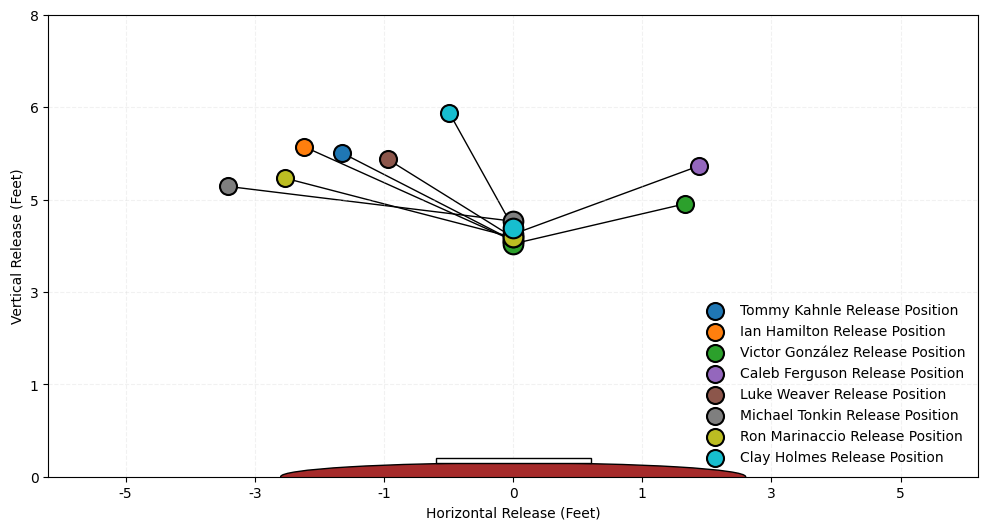

In [88]:
def plot_pitcher_arm_angle(pitcher_names, pitcher_data):
    fig, ax = plt.subplots(figsize=(12, 6))

    colors = plt.cm.get_cmap('tab10', len(pitcher_names))  # Get a color map with as many colors as pitchers

    for i, pitcher_name in enumerate(pitcher_names):
        pitcher = pitcher_data[pitcher_data['pitcher_name'] == pitcher_name]

        if pitcher.empty:
            print(f"No data for pitcher {pitcher_name}")
            continue

        x_values = np.zeros(len(pitcher['release_pos_x']))
        plt.scatter(x_values, pitcher['shoulder_pos'], s=200, lw=1.5, edgecolors='k', zorder=3, color=colors(i))
        plt.scatter(pitcher['release_pos_x'], pitcher['release_pos_z'], s=150, lw=1.5, edgecolors='k', zorder=3, label=f'{pitcher_name} Release Position', color=colors(i))

        # Draw a line between the shoulder and release point
        for j in range(len(pitcher)):
            plt.plot([0, pitcher['release_pos_x'].iloc[j]], [pitcher['shoulder_pos'].iloc[j], pitcher['release_pos_z'].iloc[j]], 'k-', lw=1, zorder=1)

    # Draw the mound as an ellipse
    mound = patches.Ellipse((0, 0), width=72, height=6, angle=0, facecolor='brown', edgecolor='black', linewidth=1, zorder=2)
    plt.gca().add_patch(mound)

    # Draw the rubber as a white rectangle with a black border
    rubber = patches.Rectangle((-12, 3), width=24, height=1, angle=0, edgecolor='black', facecolor='white', zorder=3)
    plt.gca().add_patch(rubber)

    ax.set_ylim(0, 100)
    ax.set_xlim(-72, 72)

    # Convert the x-axis to feet
    ax.set_xticklabels([f'{int(x/12)}' for x in ax.get_xticks()])
    ax.set_yticklabels([f'{int(y/12)}' for y in ax.get_yticks()])
    ax.set_ylabel('Vertical Release (Feet)')
    ax.set_xlabel('Horizontal Release (Feet)')
    ax.grid(True, linestyle='--', alpha=0.3, color='lightgray')
    # Legend bottom right with no frame
    ax.legend(loc='lower right', frameon=False)
    plt.show()

# Plot for multiple pitchers
bullpen = active_roster[active_roster['position'].isin(['RP', 'CP'])]['name'].tolist()
plot_pitcher_arm_angle(bullpen, pitcher_data)

Fetching image for Tommy Kahnle
Fetching image for Ian Hamilton
Fetching image for Victor Gonzalez
Fetching image for Caleb Ferguson
Fetching image for Luke Weaver
Fetching image for Michael Tonkin
Fetching image for Ron Marinaccio
Fetching image for Clay Holmes


findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: F

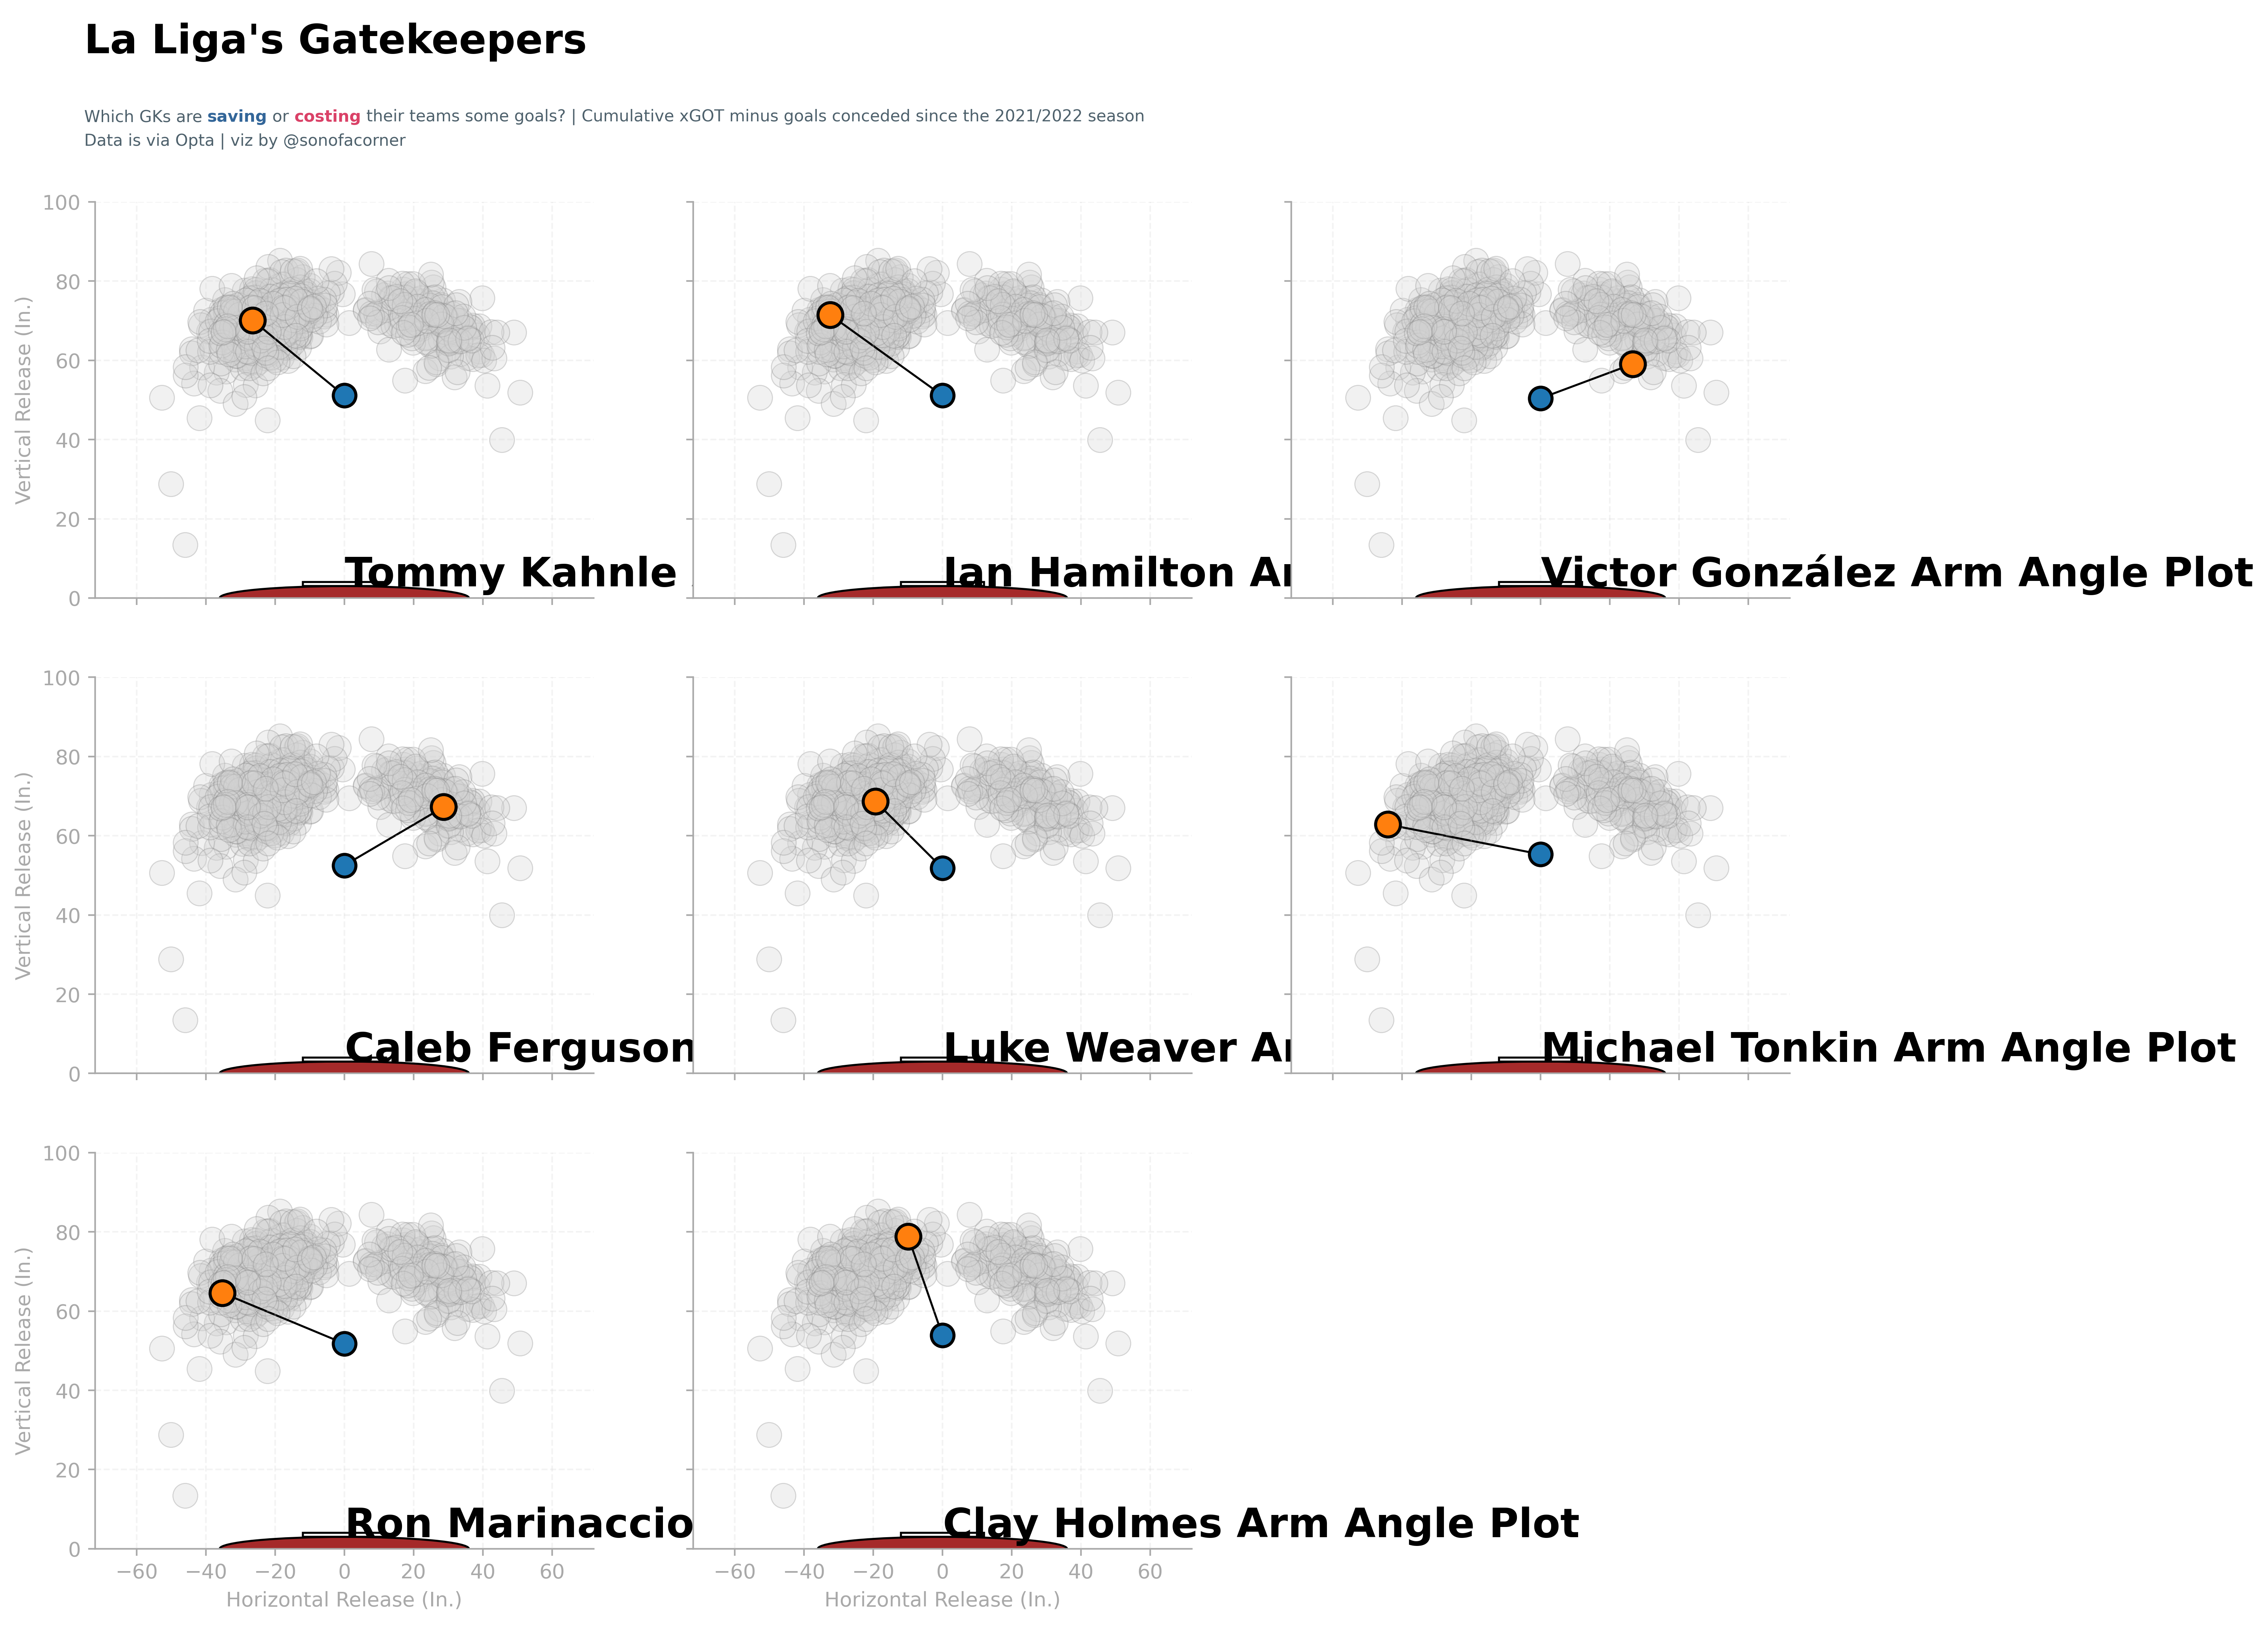

In [117]:
from matplotlib import gridspec
from unidecode import unidecode

def fetch_player_image(player_name):
    player_name = unidecode(player_name)
    print(f'Fetching image for {player_name}')
    player_id = player_info[player_info['fullName'].str.contains(player_name)].iloc[0]['id']
    url = f'https://a.espncdn.com/combiner/i?img=/i/headshots/mlb/players/full/{player_id}.png&w=350&h=254'

    response = requests.get(url)
    with open(f'player_img/{player_name}.png', 'wb') as f:
        f.write(response.content)

fig = plt.figure(figsize=(15, 12), dpi=400)
ncols = 3
nrows = len(bullpen) // ncols + (len(bullpen) % ncols > 0)
gspec = gridspec.GridSpec(nrows, ncols, figure=fig, hspace=0.2, wspace=0.2)

for i, pitcher_name in enumerate(bullpen):
    pitcher = pitcher_data[pitcher_data['pitcher_name'] == pitcher_name]
    release_pos_x = pitcher['release_pos_x'].mean()
    release_pos_z = pitcher['release_pos_z'].mean()
    angle = pitcher['arm_angle'].mean()

    # Fetch the player images
    fetch_player_image(pitcher_name)
    headshot = f'player_img/{pitcher_name}.png'

    row, col = divmod(i, ncols)
    ax = fig.add_subplot(gspec[row, col])

    x_values = np.zeros(len(pitcher['release_pos_x']))
    ax.scatter(x_values, pitcher['shoulder_pos'], s=125, lw=1.5, edgecolors='k', zorder=3, label='Shoulder Position')
    ax.scatter(pitcher['release_pos_x'], pitcher['release_pos_z'], s=150, lw=1.5, edgecolors='k', zorder=3, label='Release Position')

    # Draw a line between the shoulder and release point
    for j in range(len(pitcher)):
        ax.plot([0, pitcher['release_pos_x'].iloc[j]], [pitcher['shoulder_pos'].iloc[j], pitcher['release_pos_z'].iloc[j]], 'k-', lw=1, zorder=1)

    # Draw the mound as an ellipse
    mound = patches.Ellipse((0, 0), width=72, height=6, angle=0, facecolor='brown', edgecolor='black', linewidth=1, zorder=2)
    ax.add_patch(mound)

    # Draw the rubber as a white rectangle with a black border
    rubber = patches.Rectangle((-12, 3), width=24, height=1, angle=0, edgecolor='black', facecolor='white', zorder=3)
    ax.add_patch(rubber)
    
    # Plot the distribution of league release points
    ax.scatter(pitcher_data['release_pos_x'], pitcher_data['release_pos_z'], s=150, lw=0.5, edgecolors='gray', c='lightgray', alpha=0.3, zorder=0)
    
    ax.set_xlabel('Release Pos X')
    ax.set_ylabel('Release Pos Z / Shoulder Pos')
    ax.set_ylim(0, 100)
    ax.set_xlim(-72, 72)

    # Set tick color
    ax.tick_params(axis='x', colors='darkgray')
    ax.tick_params(axis='y', colors='darkgray')

    # Set axis label color
    ax.yaxis.label.set_color('darkgray')
    ax.xaxis.label.set_color('darkgray')
    
    ax.set_ylabel('Vertical Release (In.)')
    ax.set_xlabel('Horizontal Release (In.)')
    ax.grid(True, linestyle='--', alpha=0.25, color='lightgray')
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('darkgray')

for ax in fig.get_axes():
    ax.label_outer()

fig_text(
    x=0.12, y=.96, 
    s='La Liga\'s Gatekeepers',
    va='bottom', ha='left',
    fontsize=20, color='black', font='DM Sans', weight='bold'
)

fig_text(
	x=0.12, y=.91, 
    s='Which GKs are <saving> or <costing> their teams some goals? | Cumulative xGOT minus goals conceded since the 2021/2022 season\nData is via Opta | viz by @sonofacorner',
    highlight_textprops=[{'weight':'bold', 'color': '#336699'}, {'weight':'bold', 'color': '#DA4167'}],
	va='bottom', ha='left',
	fontsize=8, color='#4E616C', font='Karla'
)

plt.tight_layout()
plt.show()

findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.


findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: F

Processing Tommy Kahnle
Processing Ian Hamilton
Processing Victor González
Processing Caleb Ferguson
Processing Tommy Kahnle
Processing Ian Hamilton
Processing Victor González
Processing Caleb Ferguson
Processing Luke Weaver


findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: F

Processing Michael Tonkin
Processing Ron Marinaccio
Processing Clay Holmes


findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: F

Processing Luke Weaver
Processing Michael Tonkin
Processing Ron Marinaccio
Processing Clay Holmes


findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: Font family 'DM Sans' not found.
findfont: F

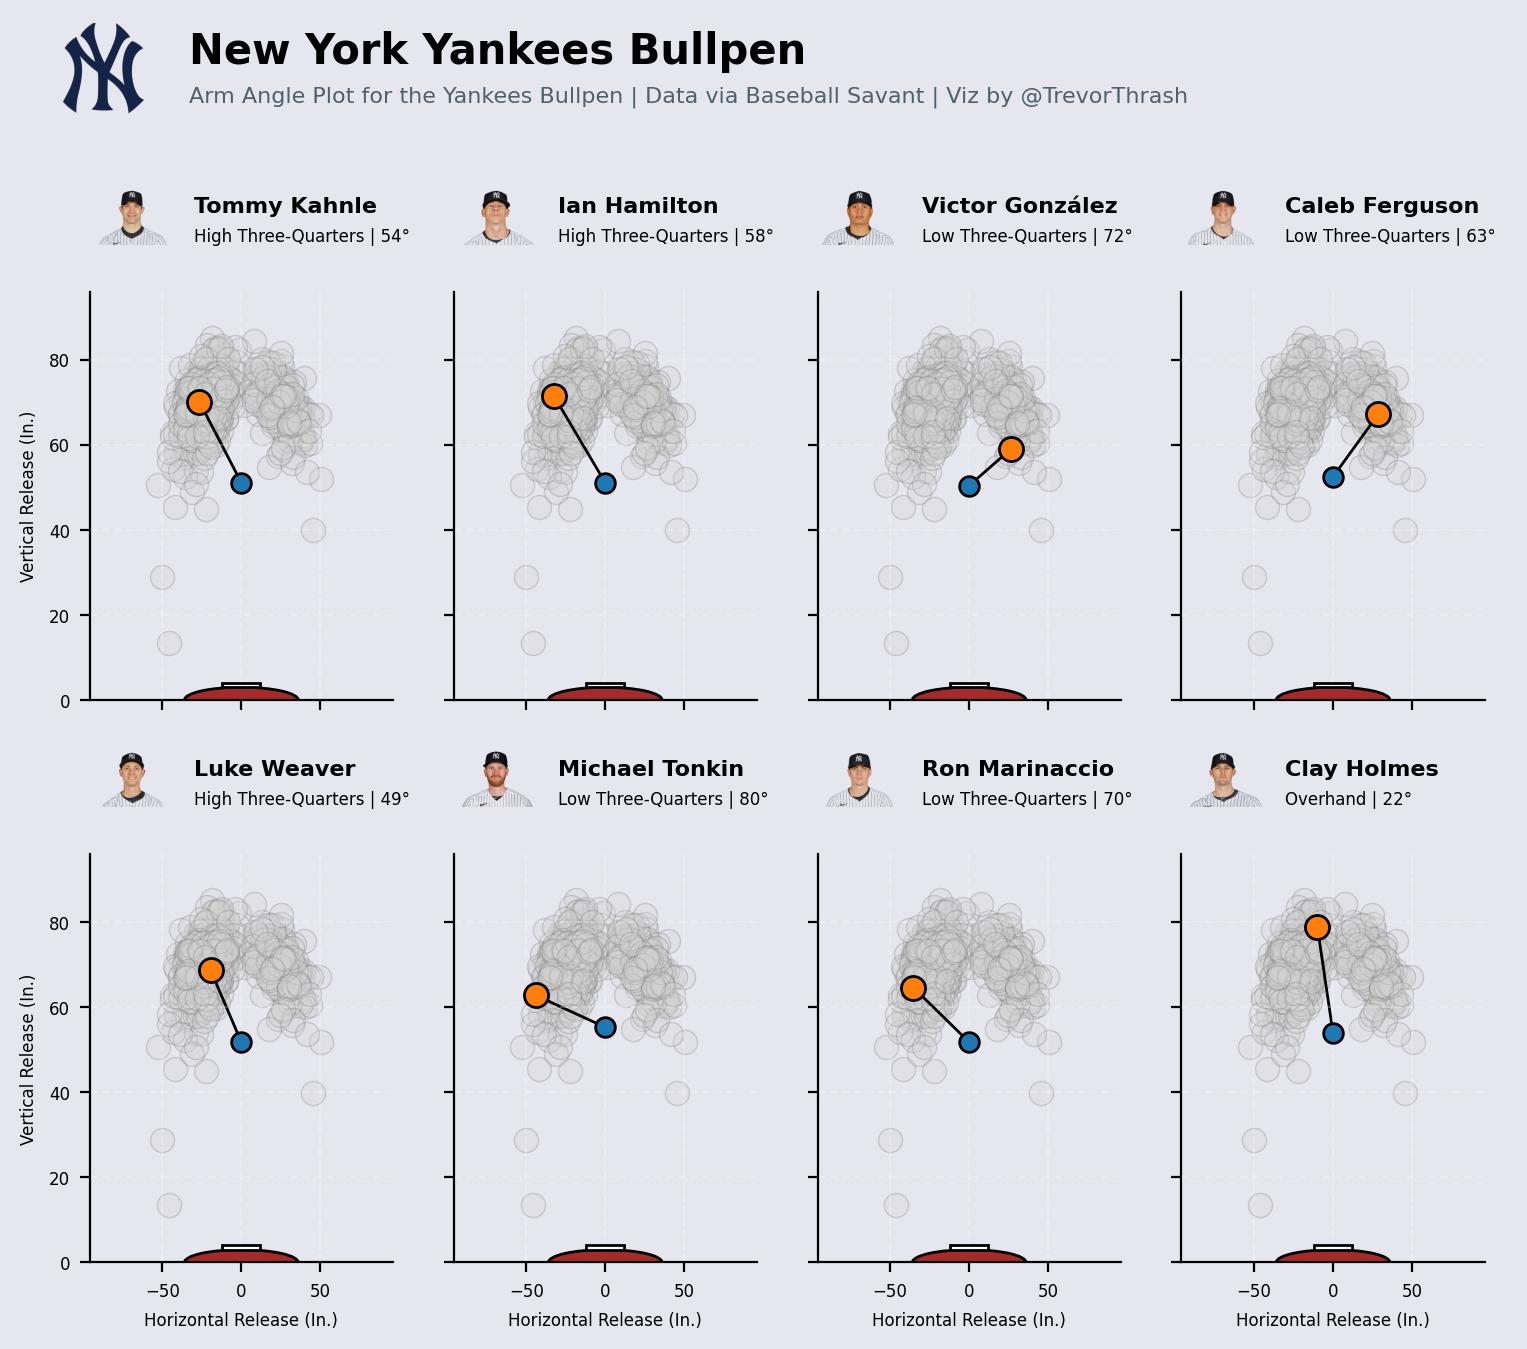

In [277]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from matplotlib import gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from unidecode import unidecode
import os
import matplotlib.patches as patches

facecolor = '#E6E6EF'
# Set up the figure and grid layout with consistent height ratios
fig = plt.figure(figsize=(9, 7), dpi=200, facecolor=facecolor)
nrows = 4
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, 
    height_ratios = [(1/nrows)*2.6 if x % 2 != 0 else (1/nrows)/2.6 for x in range(nrows)], hspace=0.2
)

plot_counter = 0
logo_counter = 0

# Loop through the grid positions
for row in range(nrows):
    for col in range(ncols):
        if plot_counter < len(bullpen):  # Ensure we only process available bullpen
            if row % 2 != 0:
                pitcher_name = bullpen[plot_counter]
                print(f'Processing {pitcher_name}')
                ax = plt.subplot(gspec[row, col], facecolor=facecolor)
                pitcher = pitcher_data[pitcher_data['pitcher_name'] == pitcher_name]

                x_values = np.zeros(len(pitcher['release_pos_x']))
                ax.scatter(x_values, pitcher['shoulder_pos'], s=50, lw=1, edgecolors='k', zorder=3, label='Shoulder Position')
                ax.scatter(pitcher['release_pos_x'], pitcher['release_pos_z'], s=75, lw=1, edgecolors='k', zorder=3, label='Release Position')

                # Draw a line between the shoulder and release point
                for j in range(len(pitcher)):
                    ax.plot([0, pitcher['release_pos_x'].iloc[j]], [pitcher['shoulder_pos'].iloc[j], pitcher['release_pos_z'].iloc[j]], 'k-', lw=1, zorder=1)

                # Draw the mound as an ellipse
                mound = patches.Ellipse((0, 0), width=72, height=6, angle=0, facecolor='brown', edgecolor='black', linewidth=1, zorder=2)
                ax.add_patch(mound)

                # Draw the rubber as a white rectangle with a black border
                rubber = patches.Rectangle((-12, 3), width=24, height=1, angle=0, edgecolor='black', facecolor='white', zorder=3)
                ax.add_patch(rubber)

                # Plot the distribution of league release points
                ax.scatter(pitcher_data['release_pos_x'], pitcher_data['release_pos_z'], s=75, lw=0.5, edgecolors='gray', c='lightgray', alpha=0.3, zorder=0)

                ax.set_xlabel('Release Pos X')
                ax.set_ylabel('Release Pos Z / Shoulder Pos')

                # Set tick color
                ax.tick_params(axis='x', colors='k', labelsize=6)
                ax.tick_params(axis='y', colors='k', labelsize=6)

                # Set axis label color
                ax.yaxis.label.set_color('k')
                ax.xaxis.label.set_color('k')

                # Set x and y lim
                ax.set_ylim(0, 96)
                ax.set_xlim(-96, 96)

                ax.set_ylabel('Vertical Release (In.)', fontsize=6)
                ax.set_xlabel('Horizontal Release (In.)', fontsize=6)
                ax.grid(True, linestyle='--', alpha=0.25, color='white')
                ax.spines[['top', 'right']].set_visible(False)
                ax.spines[['left', 'bottom']].set_color('k')

                plot_counter += 1
            else:
                logo_ax = plt.subplot(gspec[row, col], anchor='NW', facecolor=facecolor)
                pitcher_name = bullpen[logo_counter]
                print(f'Processing {pitcher_name}')
                headshot = fetch_player_image(pitcher_name)
                arm_slot_type = pitcher_data[pitcher_data['pitcher_name'] == pitcher_name]['arm_angle_type'].iloc[0]
                angle = pitcher_data[pitcher_data['pitcher_name'] == pitcher_name]['arm_angle'].mean()

                # Display the player headshot image
                img = Image.open(headshot)
                logo_ax.imshow(img)
                logo_ax.axis('off')
                ax_text(
                    x = 1.25, 
                    y = .8,
                    s = f'<{pitcher_name}> \n{arm_slot_type} | {angle:.0f}°',
                    ax = logo_ax, 
                    highlight_textprops=[{'weight':'bold', 'font':'DM Sans', 'size':'8'}],
                    ha = 'left', 
                    size = 6, 
                    annotationbbox_kw = {'xycoords':'axes fraction'}
                )
                logo_counter += 1

for ax in fig.get_axes():
    ax.label_outer()

fig_text(
    x=0.18, y=.96, 
    s='New York Yankees Bullpen',
    va='bottom', ha='left',
    fontsize=15, color='black', weight='bold'
)
fig_text(
	x=0.18, y=.935, 
    s='Arm Angle Plot for the Yankees Bullpen | Data via Baseball Savant | Viz by @TrevorThrash',
	va='bottom', ha='left',
	fontsize=8, color='#4E616C'
)
logo_ax = fig.add_axes(
    [.1, .93, .065, .065]
)
team_logo = Image.open('New_York_Yankees_logo.png')
logo_ax.imshow(team_logo)
logo_ax.axis('off')

plt.tight_layout()
plt.show()
